In [1]:
import pandas as pd
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import math
import numpy as np
from tqdm import tqdm
import random
import cv2
from PIL import Image
from torchvision.utils import save_image
from torchvision.models import ResNet18_Weights
from torchvision import models
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
to_img = ToPILImage()

In [3]:
class VGG16(nn.Module):
    def __init__(self, num_embed=1000):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=9, stride=1, padding=1),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(13456, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_embed))
        #self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.softmax(out)
        return out

In [4]:
class VGG16_reverse(nn.Module):
    def __init__(self, num_embed=1000):
        super(VGG16_reverse, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_embed, 4096))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 13456),
            nn.ReLU())
        self.layer1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer2 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer3 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer4 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer5 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer6 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer7 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer8 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=9, stride=1, padding=1))
        self.layer9 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=9, stride=1, padding=1))
        
    def forward(self, x, len_batch):
        out = self.fc(x)
        out = self.fc1(out)
        out = self.fc2(out)
        #print(out.shape)
        out = out.reshape(len_batch, 4, 58, 58)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        #print(out.shape)
        return out
    


In [5]:
class Decoder(nn.Module):
    def __init__(self,in_channels=512):
        super(Decoder, self).__init__()
#         self.conv1 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3,padding=1),
#                                    nn.BatchNorm2d(512),
#                                    nn.ReLU(inplace=True))
        
        self.upconv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=256, kernel_size=2,stride=2)
        self.conv2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(256),
#                                    nn.ReLU(inplace=True),
#                                    nn.Conv2d(256, 256, kernel_size=3,padding=1),
#                                    nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True))
        
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(128),
#                                    nn.ReLU(inplace=True),
#                                    nn.Conv2d(128, 128, kernel_size=3,padding=1),
#                                    nn.BatchNorm2d(128),
                                   nn.ReLU(inplace=True))
        
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(64),
#                                    nn.ReLU(inplace=True),
#                                    nn.Conv2d(64, 64, kernel_size=3,padding=1),
#                                    nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2,stride=2)
        self.conv5 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2,stride=2)
        self.conv6 = nn.Sequential(nn.Conv2d(16, 3, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(3),
                                   nn.Sigmoid())
        
        
    def forward(self, x):
#         x = self.conv1(x)
        
        x = self.upconv1(x)
        x = self.conv2(x)+x
        
        x = self.upconv2(x)
        x = self.conv3(x)+x
        
        x = self.upconv3(x)
        x = self.conv4(x)+x
        x = self.upconv4(x)
        x = self.conv5(x)+x
        x = self.upconv5(x)
        x = self.conv6(x)
        return x

In [6]:
class autocoder_vgg(nn.Module):
    def __init__(self, num_embed=1000):
        super(autocoder_vgg, self).__init__()
        self.coder = VGG16(1000)
        self.decoder = VGG16_reverse(1000)
    def forward(self, x, level, stage, len_batch):
        embed = self.coder(x)
        if stage == 'train':
            embed = train_noise(embed, level)
        else:
            embed = kvantovanie(embed, level)
        x = self.decoder(embed, len_batch)
        return x

In [7]:
class autocoder_res(nn.Module):
    def __init__(self):
        super(autocoder_res, self).__init__()
        self.coder = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.coder = nn.Sequential(*list(self.coder.children())[:-2])
        #self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.decoder = Decoder()
    def forward(self,x, level, stage):
        embed = self.coder(x)
        embed = self.sigmoid(embed)
        if stage == 'train':
            embed = train_noise(embed, level)
        else:
            embed = kvantovanie(embed, level)
        x = self.decoder(embed.float())
        return x

In [8]:
def noise():
    while (True):
        some = np.random.normal()
        if some > -0.5 and some < 0.5:
            break
    return some

def kvantovanie(batch, level):
    
    #for int_batch in range(0, len(batch)):
    #    for int_vect in range(0, len(batch[0])):
    #        batch[int_batch][int_vect] = batch[int_batch][int_vect]*2**level + 0.5
    #        batch[int_batch][int_vect] = math.floor(batch[int_batch][int_vect])
    return torch.floor(batch*(2**level) + 0.5)

def train_noise(batch, level):
    #print(batch[0][0])
    #for int_batch in range(0, len(batch)):
    #    for int_vect in range(0, len(batch[0])):
    #        batch[int_batch][int_vect] = batch[int_batch][int_vect] + (1/(2**level))*noise()
    
    return batch + (1/(2**level))*noise()

In [9]:
def kvantovanie(batch, level):
    matrix = np.fromfunction(lambda b, i, j, k: (k+1)/(k+1)*(1/2**level)*random.normalvariate(-0.5, 0.5), (batch.shape[0], 512, 16, 16), dtype=float)
    return torch.floor(batch + torch.from_numpy(matrix).to('cuda'))

def train_noise(batch, level):
    matrix = np.fromfunction(lambda b, i, j, k: (k+1)/(k+1)*(2**level), (batch.shape[0], 512, 16, 16), dtype=float)
    return batch*torch.from_numpy(matrix).to('cuda') + 0.5

In [10]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms normalize,
    transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )
    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_idx = train_idx[:1000]
    valid_idx = valid_idx[:100]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

batch_size = 8
# CIFAR100 dataset 
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=batch_size)

test_loader = data_loader(data_dir='./data',
                              batch_size=batch_size,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
#model = autocoder().to(device)
model = autocoder_res().to(device)
#margin = 500
epox_num = 25
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
def train_model(model, criterion, optimizer, level, num_epochs=3):
    to_img = ToPILImage()
    loss_list = {'train' : [], 'test':[]}
    acc_list = {'train' : [], 'test':[]}
    rec_list = {'train' : [], 'test':[]}
    for epoch in range(num_epochs):
        running_loss = 0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataset = train_loader
            else:
                model.eval()
                dataset = valid_loader
            for image, labels in tqdm(dataset):
                image = image.to(device)
                labels = labels.to(device)
                #outputs = model(image, level, phase, len(image))
                outputs = model(image, level, phase)
                loss = criterion(outputs, image)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()# * inputs.size(0)
            epoch_loss = running_loss / (len(dataset)*batch_size)
            
            plt.imshow(image[0].to('cpu').permute(1, 2, 0).detach().numpy())
            plt.show()
            plt.imshow(outputs[0].to('cpu').permute(1, 2, 0).detach().numpy())
            plt.show()
            print('{} loss: {:.10f}'.format(phase, epoch_loss))
            

Epoch 1/25
----------


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:24<00:00,  5.07it/s]


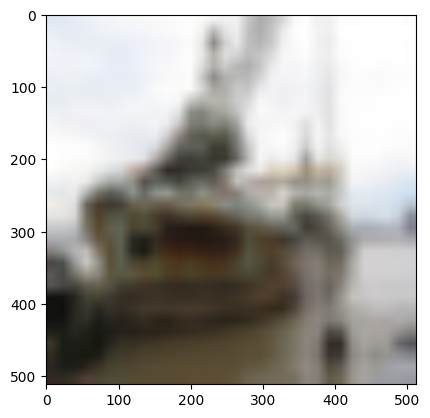

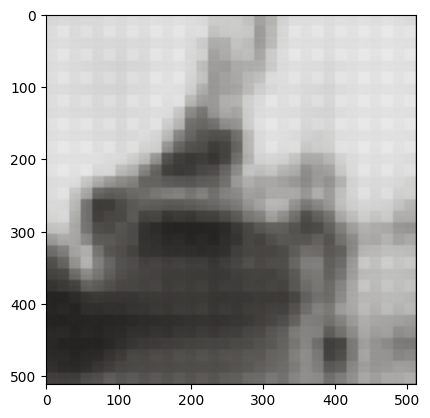

train loss: 0.0024184422


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.18it/s]


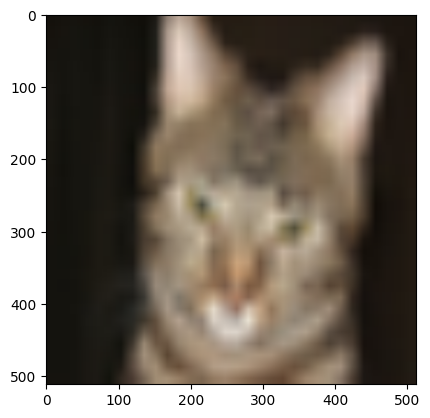

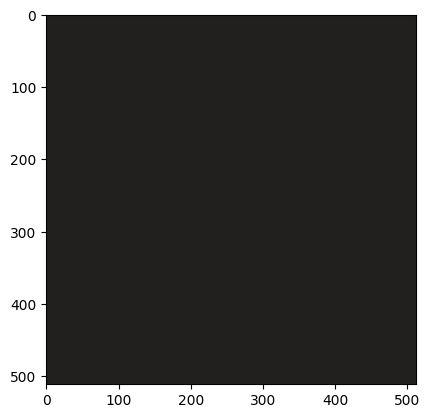

val loss: 0.0456177011
Epoch 2/25
----------


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:22<00:00,  5.50it/s]


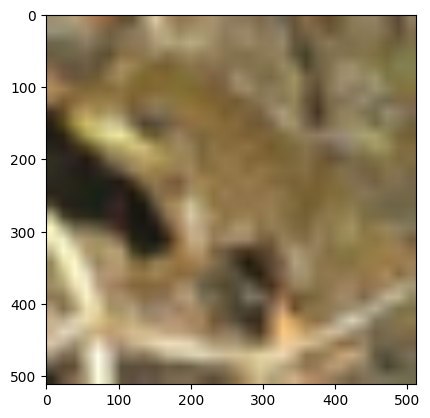

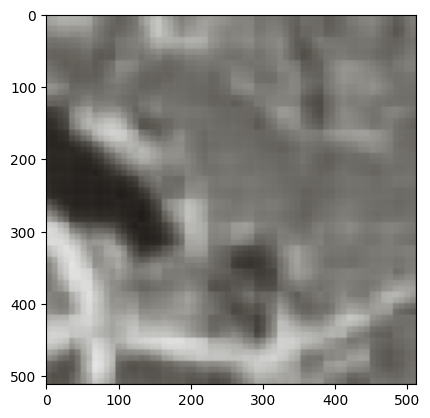

train loss: 0.0012587175


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.65it/s]


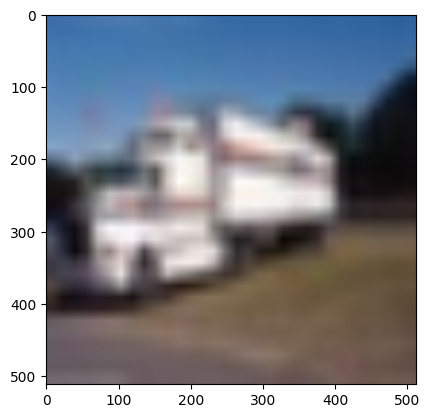

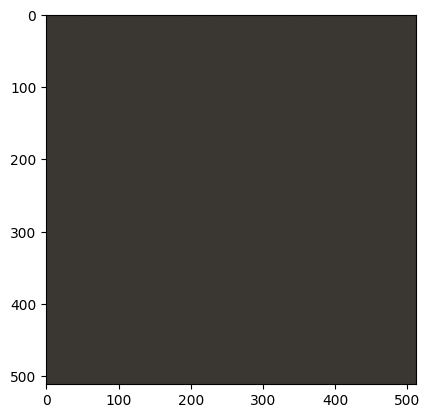

val loss: 0.0279300072
Epoch 3/25
----------


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:22<00:00,  5.57it/s]


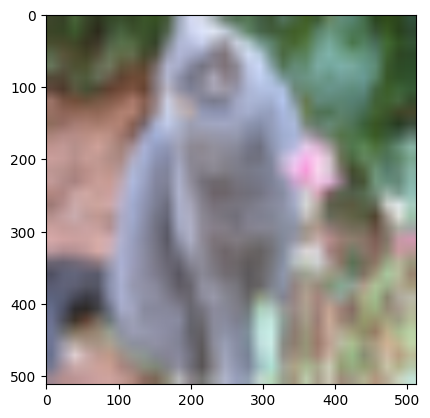

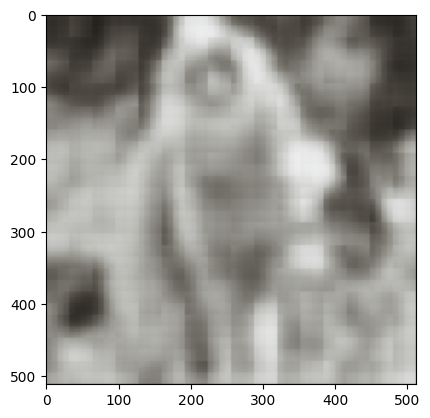

train loss: 0.0011520921


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.70it/s]


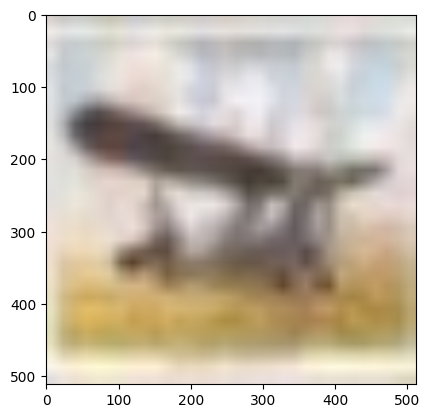

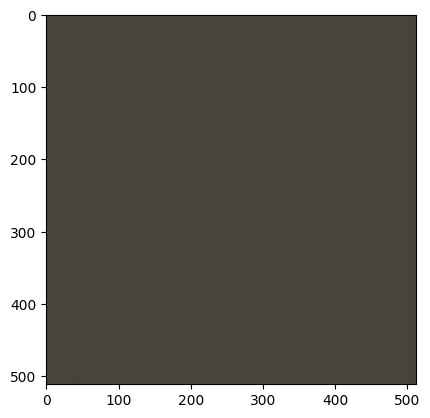

val loss: 0.0243385371
Epoch 4/25
----------


 58%|██████████████████████████████████████████████▋                                  | 72/125 [00:13<00:09,  5.52it/s]


KeyboardInterrupt: 

In [14]:
train_model(model, criterion, optimizer, 6, epox_num)

In [16]:
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])

    # define transforms normalize
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            ])

In [17]:
img1 = Image.open('baboon.png')
tenz1 = transform(img1)
#tenz1 = torch.cat([tenz1])

img2 = Image.open('lena.png')
#img2 = img2.convert('RGB')
tenz2 = transform(img2)

img3 = Image.open('peppers.png')
#img3 = img3.convert('RGB')
tenz3 = transform(img3)


In [ ]:

to_img(tenz1)

In [27]:
batch = torch.stack((tenz1, tenz2, tenz3), -1)
batch

tensor([[[[0.6431, 0.8863, 0.3961],
          [0.2471, 0.8863, 0.5490],
          [0.2941, 0.8745, 0.5922],
          ...,
          [0.4588, 0.9020, 0.7529],
          [0.5529, 0.8667, 0.8039],
          [0.7020, 0.7843, 0.4706]],

         [[0.4706, 0.8863, 0.4824],
          [0.5294, 0.8863, 0.7490],
          [0.2157, 0.8745, 0.7451],
          ...,
          [0.4784, 0.9020, 0.6039],
          [0.5333, 0.8667, 0.5333],
          [0.4706, 0.7843, 0.4510]],

         [[0.3882, 0.8863, 0.4941],
          [0.5176, 0.8863, 0.7255],
          [0.2353, 0.8745, 0.7255],
          ...,
          [0.4627, 0.9020, 0.5647],
          [0.3412, 0.8667, 0.5804],
          [0.3765, 0.7843, 0.4431]],

         ...,

         [[0.4745, 0.3294, 0.3608],
          [0.4824, 0.3294, 0.4980],
          [0.4863, 0.3608, 0.5333],
          ...,
          [0.4314, 0.6784, 0.7098],
          [0.3529, 0.6745, 0.6941],
          [0.3176, 0.6941, 0.7412]],

         [[0.4941, 0.3216, 0.3608],
          [0.4588

In [26]:
#[32, 3, 112, 112]
batch.shape

torch.Size([3, 512, 512, 3])

In [19]:
batch_new = batch.permute(0, 3, 1, 2)

In [20]:
#out = model(batch_new.to(device), 2, 'some', 3)
out = model(batch_new.to(device), 2, 'some')

In [ ]:
to_img

In [ ]:

to_img(img1).show()
f = 7
#save_image(img1, 'img1.png')

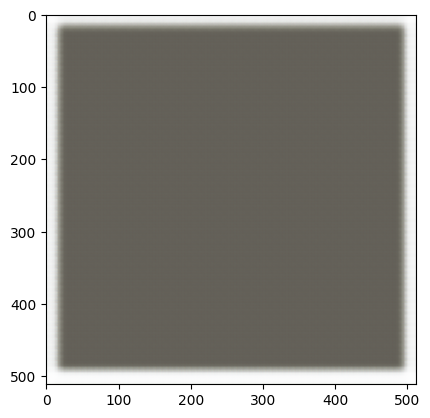

1


In [22]:
img1 = out[1].to('cpu')
plt.imshow(img1.to('cpu').permute(1, 2, 0).detach().numpy())
plt.show()
print(1)

In [25]:
out[2]

tensor([[[0.8995, 0.9226, 0.9479,  ..., 0.9412, 0.9483, 0.9068],
         [0.9394, 0.9738, 0.9736,  ..., 0.9848, 0.9785, 0.9702],
         [0.9433, 0.9688, 0.9775,  ..., 0.9785, 0.9773, 0.9491],
         ...,
         [0.9504, 0.9784, 0.9813,  ..., 0.9887, 0.9828, 0.9687],
         [0.9469, 0.9757, 0.9791,  ..., 0.9788, 0.9803, 0.9395],
         [0.8963, 0.9423, 0.9433,  ..., 0.9560, 0.9431, 0.9259]],

        [[0.8965, 0.9504, 0.9579,  ..., 0.9639, 0.9680, 0.9132],
         [0.9425, 0.9725, 0.9826,  ..., 0.9805, 0.9848, 0.9460],
         [0.9364, 0.9789, 0.9795,  ..., 0.9868, 0.9855, 0.9574],
         ...,
         [0.9475, 0.9803, 0.9850,  ..., 0.9845, 0.9871, 0.9566],
         [0.9432, 0.9791, 0.9813,  ..., 0.9859, 0.9838, 0.9557],
         [0.8726, 0.9544, 0.9561,  ..., 0.9632, 0.9610, 0.9101]],

        [[0.8974, 0.9444, 0.9599,  ..., 0.9631, 0.9637, 0.9229],
         [0.9350, 0.9685, 0.9776,  ..., 0.9806, 0.9781, 0.9555],
         [0.9487, 0.9770, 0.9840,  ..., 0.9859, 0.9852, 0.

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth)

In [ ]:
len(batch)

In [ ]:
tenz1

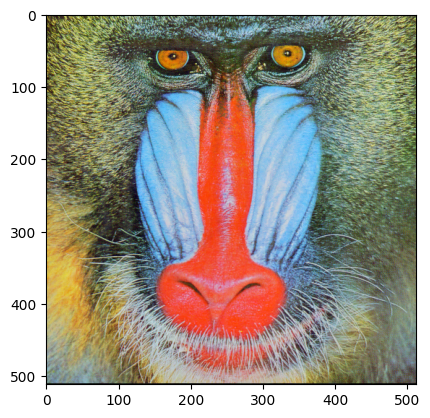

In [30]:
im = Image.open(r'baboon.png')
im.convert("RGBA").save('baboon.jp2', 'JPEG2000', quality_mode='dB', quality_layers=[40])
plt.imshow(Image.open('baboon.jp2'))
plt.show()

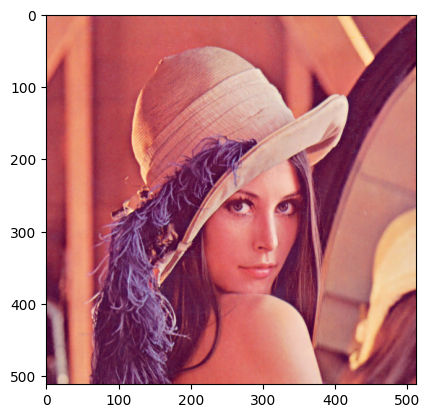

In [47]:
im = Image.open(r'lena.png')
im.convert("RGBA").save('lena_3.jp2', 'JPEG2000', quality_mode='dB', quality_layers=[60])
plt.imshow(Image.open('lena.jp2'))
plt.show()

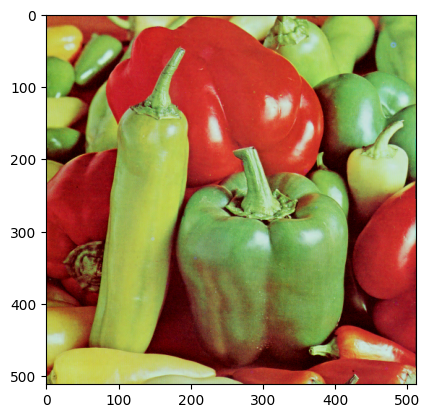

In [44]:
im = Image.open(r'peppers.png')
im.convert("RGBA").save('peppers_1.jp2', 'JPEG2000', quality_mode='dB', quality_layers=[20])
plt.imshow(Image.open('peppers.jp2'))
plt.show()

In [19]:
size_bits = int(os.stat('lena.png').st_size/8)
im = Image.open('lena.png')
width, height = im.size
size_pexils = width * height
bpp_orig = size_bits/size_pexils




In [20]:
size_bits = int(os.stat('lena_1.jp2').st_size/8)
im = Image.open('lena_1.jp2')
width, height = im.size
size_pexils = width * height*3
bpp_jp2_1 = size_bits/size_pexils

In [21]:
size_bits = int(os.stat('lena_2.jp2').st_size/8)
im = Image.open('lena_2.jp2')
width, height = im.size
size_pexils = width * height*3
bpp_jp2_2 = size_bits/size_pexils

In [22]:
size_bits = int(os.stat('lena_3.jp2').st_size/8)
im = Image.open('lena_3.jp2')
width, height = im.size
size_pexils = width * height*3
bpp_jp2_3 = size_bits/size_pexils

In [16]:

psnr_1 = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_1.jp2'))
psnr_2 = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_2.jp2'))
psnr_3 = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_3.jp2'))

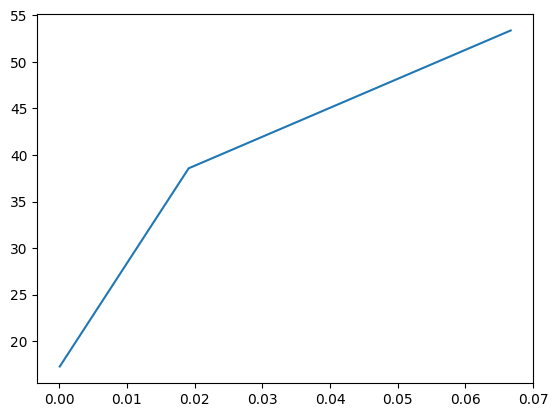

In [58]:
plt.plot([bpp_jp2_1, bpp_jp2_2, bpp_jp2_3], [psnr_1, psnr_2, psnr_3])

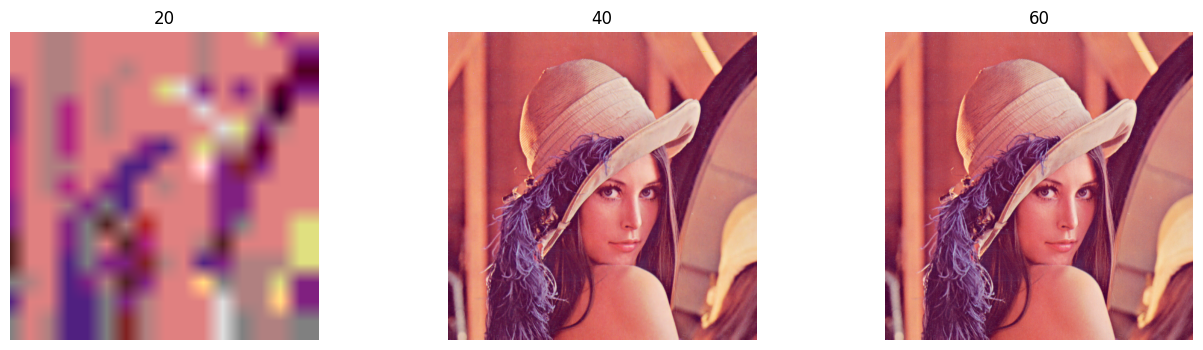

In [7]:
pic_box = plt.figure(figsize=(16,4))
img1 = cv2.imread('lena_1.jp2')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('lena_2.jp2')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread('lena_3.jp2')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
pic_box.add_subplot(1,3,1)
plt.imshow(img1)
plt.axis('off')
plt.title("20")
pic_box.add_subplot(1,3,2)
plt.imshow(img2)
plt.axis('off')
plt.title("40")
pic_box.add_subplot(1,3,3)
plt.imshow(img3)
plt.axis('off')
plt.title("60")
plt.show()

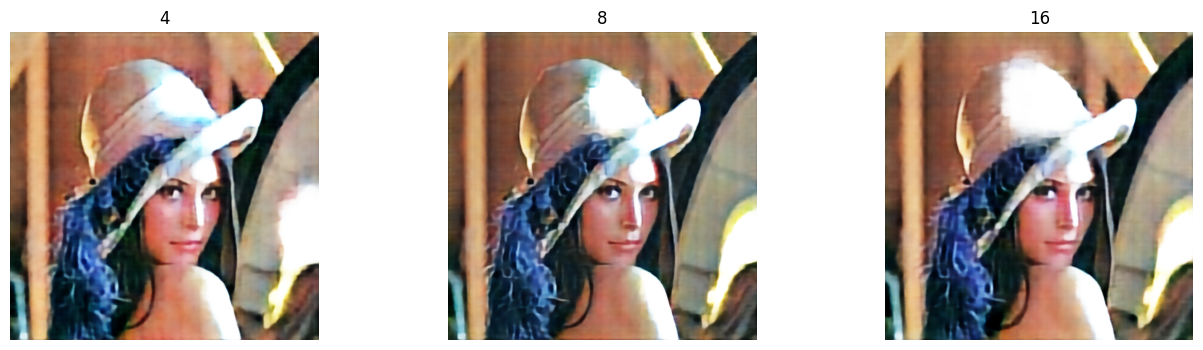

In [11]:
pic_box = plt.figure(figsize=(16,4))
img1 = cv2.imread('lena_decomp_4.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('lena_decomp_8.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread('lena_decomp_16.png')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
pic_box.add_subplot(1,3,1)
plt.imshow(img1)
plt.axis('off')
plt.title("4")
pic_box.add_subplot(1,3,2)
plt.imshow(img2)
plt.axis('off')
plt.title("8")
pic_box.add_subplot(1,3,3)
plt.imshow(img3)
plt.axis('off')
plt.title("16")
plt.show()

In [12]:
size_bits = int(os.stat('lena_decomp_4.png').st_size/8)
im = Image.open('lena_decomp_4.png')
width, height = im.size
size_pexils = width * height*3
bpp_net_1 = size_bits/size_pexils

In [13]:
size_bits = int(os.stat('lena_decomp_8.png').st_size/8)
im = Image.open('lena_decomp_8.png')
width, height = im.size
size_pexils = width * height*3
bpp_net_2 = size_bits/size_pexils

In [14]:
size_bits = int(os.stat('lena_decomp_16.png').st_size/8)
im = Image.open('lena_decomp_16.png')
width, height = im.size
size_pexils = width * height*3
bpp_net_3 = size_bits/size_pexils

In [17]:
psnr_1_net = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_decomp_4.png'))
psnr_2_net = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_decomp_8.png'))
psnr_3_net = cv2.PSNR(cv2.imread('lena.png'), cv2.imread('lena_decomp_16.png'))

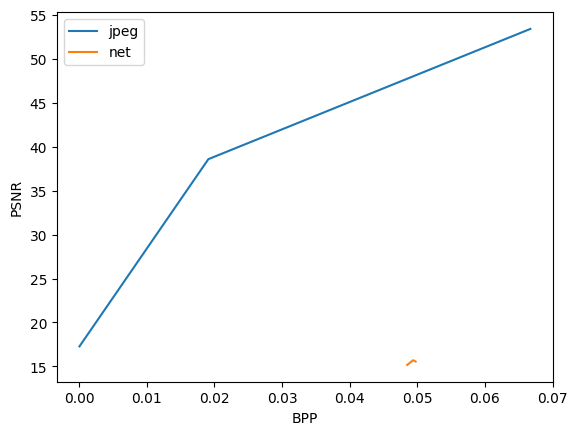

In [26]:
fig, ax = plt.subplots() 
ax.plot([bpp_jp2_1, bpp_jp2_2, bpp_jp2_3], [psnr_1, psnr_2, psnr_3], label='jpeg') 
ax.plot([bpp_net_1, bpp_net_2, bpp_net_3], [psnr_1_net, psnr_2_net, psnr_3_net], label='net') 
leg = ax.legend()
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.show() 